# 基于MindSpore Quantum的Grover搜索算法和龙算法

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_grover_search_algorithm.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_grover_search_algorithm.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/case_library/grover_search_algorithm.ipynb)

## 概述

如果你听过量子计算，那么你一定听说过Grover搜索算法。1996年，Lov Grover \[1\] 提出了Grover搜索算法，它是一种利用量子状态的叠加性进行并行计算并实现加速的算法。Grover搜索算法被公认为是继Shor算法后的第二大量子算法，也是第一个被完整的实验实现的量子算法，它解决的是无序数据库搜索问题。1997年，Bennett \[2\] 等人证明，对于非结构化的量子搜索问题，至少需要$\Omega(\sqrt{N})$​次量子查询，因此Grover搜索算法对于该问题是渐进意义下的最优算法。

无序数据库搜索问题（Unordered  Database Search problem）就是从一个海量元素的无序数据库中，找到某些满足要求的元素。由于数据库中元素的数量是巨大的且这些元素是无序排列的，所以，要验证给定的元素是否满足要求很容易，但反过来，要找到这些元素却不是一件容易的事。

求解无序数据库搜索问题（不妨假设只有一个目标搜索数据），经典算法所需的时间复杂度为$\mathcal{O}(N)$，而Grover搜索算法所需的时间复杂度仅为$\mathcal{O}(\sqrt{N})$，相比经典算法具有平方加速，展示了量子计算的强大性能。此外，Grover搜索算法中用到的振幅扩大技巧，对许多启发式的经典搜索算法可以实现加速，因而具有广泛的应用。

本文档将会介绍Grover搜索算法的基本原理，以及通过两个具体的小例子来展示如何利用MindSpore Quantum实现该算法。

## 问题描述

我们需要在一组无序的$N$元素集合（数据库）中进行搜索。将数据库中的元素与索引（从$0$到$N-1$之间的整数）建立一一对应，我们关注于搜索这些元素的索引。考虑将该搜索问题表示为一个关于输入$x$的函数$f(x)$，其中$x$为$0$到$N-1$之间的整数。那么，函数$f$定义为：

$$
\begin{equation}
f(x)=\begin{cases}0,x\neq x_{target}\\\\
1,x=x_{target}
\end{cases}
\end{equation}.
$$

不失一般性，假设$N=2^n$​，那么在量子系统中，索引以量子态$|0\rangle,|1\rangle,...,|N-1\rangle$​（或$|00...0\rangle,|00...1\rangle,...,|11...1\rangle$​）表示，也即我们可以使用$n$​个量子比特存储这些索引。

同时假设搜索问题只有一个目标态$|\omega\rangle$。Grover搜索算法的目标就是以极大的概率将$|\omega\rangle$搜索出来。

## Grover搜索算法的基本原理

Grover搜索算法的基本原理：首先通过 [Hadamard](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html) 门产生均匀叠加态，然后反复调用Grover迭代（或称为$G$算子），以放大目标项的概率振幅同时抑制非目标项的概率振幅（该方法称之为振幅放大），最后对末态进行测量，那么就能以极大的概率得到目标态$|\omega\rangle$​​。

下面介绍Grover算法的主要步骤。

### Step 1：数据库初始化

对$|0\rangle^{\otimes n}$​​​​执行$H^{\otimes n}$​​​​​操作，使得数据库被初始为一个均匀叠加态，即

$$
|\psi_0\rangle=H^{\otimes n}|0\rangle^{\otimes n}=\frac{1}{\sqrt{N}}\sum_{i=0}^{N-1}|i\rangle.
$$

### Step 2：Grover迭代

Grover迭代又可以分解为四步：

#### 子步骤一

执行Oracle算子$U_{\omega}$​，翻转目标态$|\omega \rangle$​​​​​的相位。

为了将需要寻找的数据和其它的数据区别开，最简单的方法就是翻转目标态的相位（增加一个负号），此时我们需要构造一个Oracle算子$U_{\omega}$，其作用如下：

$$
\begin{equation}
U_{\omega}|x\rangle=\begin{cases}
&|x\rangle,x\neq \omega&\\\\
-&|x\rangle,x=\omega&
\end{cases}
\end{equation}.
$$

由于当$x=\omega$​时，$f(\omega)=1$​，那么$U_{\omega}$​​的作用还可以表示成：

$$
U_{\omega}|x\rangle=(-1)^{f(x)}|x\rangle,
$$

其矩阵表达式为

$$
\begin{equation}
U_{\omega}=
\left[
\begin{array}{ccc}
     (-1)^{f(0)} & 0           & \dots  & 0            \\\\
     0           & (-1)^{f(1)} & \dots  & 0            \\\\
     \vdots      & \vdots      & \ddots & \vdots       \\\\
     0           & 0           & \dots  & (-1)^{f(N-1)}
\end{array}
\right]
\end{equation}.
$$

#### 子步骤二

执行$H^{\otimes n}$操作。

对$n$位量子比特执行$H^{\otimes n}$操作。

#### 子步骤三

执行条件相移算子$P$。

条件相移算子$P$能使$|0\rangle$​态以外的每个态的相位都翻转，其作用如下：

$$
\begin{equation}
P|x\rangle=\begin{cases}&|0\rangle,x= 0&\\\\
-&|x\rangle,x\neq0&
\end{cases}
\end{equation}.
$$

其矩阵表达式为

$$
\begin{equation}
P = 2(|0\rangle\langle0|)^{\otimes n} - I_n =
\left[
\begin{array}{ccc}
     1      & 0      & \dots  & 0            \\\\
     0      & -1     & \dots  & 0            \\\\
     \vdots & \vdots & \ddots & \vdots       \\\\
     0      & 0      & \dots  & -1
\end{array}
\right]
\end{equation}.
$$

#### 子步骤四

再次执行$H^{\otimes n}$操作。

至此，完整的$G$算子可以表示为

$$
G = H^{\otimes n} [2(|0\rangle\langle0|)^{\otimes n} - I_n] H^{\otimes n} U_{\omega}.
$$

注意：$G$算子需要迭代的次数为

$$
r = \left[ \frac{\pi}{4} \sqrt{\frac{N}{M}} \right] \sim O(\sqrt{N}),
$$

其中，M表示目标态的个数。

### Step 3：测量

对末态进行$\\{|0\rangle,|1\rangle\\}$基测量，就能以极大的概率得到目标态$|\omega \rangle$。

Grover搜索算法的完整量子线路模型如下所示：

![grover algorithm circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/grover_algorithm_circuit.png)

## 构造翻转量子比特相位的酉算子

通过上述介绍，我们发现，Grover搜索算法中最关键的部分就是存在可以翻转量子比特相位的酉算子，Oracle算子$U_{\omega}$可以翻转目标态的相位，条件相移算子$P$可以翻转$|0\rangle$态以外的每个态的相位。

接下来，我们将构造可以翻转某一位量子比特相位的酉算子，定义如下：

In [1]:
from mindquantum.core.circuit import Circuit
from mindquantum.core.gates import Z

def bitphaseflip_operator(phase_inversion_qubit, n_qubits):   # 定义可以翻转某一位量子比特相位的函数
    s = [1 for i in range(1 << n_qubits)]
    for i in phase_inversion_qubit:
        s[i] = -1
    if s[0] == -1:
        for i in range(len(s)):
            s[i] = -1 * s[i]
    circuit = Circuit()
    length = len(s)
    cz = []
    for i in range(length):
        if s[i] == -1:
            cz.append([])
            current = i
            t = 0
            while current != 0:
                if (current & 1) == 1:
                    cz[-1].append(t)
                t += 1
                current = current >> 1
            for j in range(i + 1, length):
                if i & j == i:
                    s[j] = -1 * s[j]
    for i in cz:
        if i:
            if len(i) > 1:
                circuit += Z.on(i[-1], i[:-1])
            else:
                circuit += Z.on(i[0])

    return circuit

现在， `bitphaseflip_operator()` 函数就可以实现翻转某一位量子比特的相位，只需要输入需要翻转相位的目标量子态和量子比特总数即可。

举个例子，我们现在生成3​​量子比特的均匀叠加态，运行如下代码：

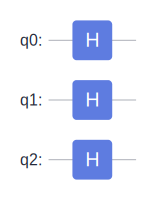

In [2]:
# pylint: disable=W0104
from mindquantum.core.circuit import UN
from mindquantum.core.gates import H
from mindquantum.simulator import Simulator

n_qubits = 3                                 # 设定量子比特数为3
sim = Simulator('mqvector', n_qubits)        # 使用mqvector模拟器，命名为sim

circuit = Circuit()                          # 初始化量子线路，命名为circuit
circuit += UN(H, n_qubits)                   # 每位量子比特上执行H门操作

sim.apply_circuit(circuit)                   # 通过模拟器sim运行搭建好的量子线路circuit

circuit.svg()                                # 打印此时的量子线路circuit

In [3]:
print(sim.get_qs(True))                      # 打印模拟器sim中运行量子线路circuit后的末态

√2/4¦000⟩
√2/4¦001⟩
√2/4¦010⟩
√2/4¦011⟩
√2/4¦100⟩
√2/4¦101⟩
√2/4¦110⟩
√2/4¦111⟩


从运行的结果看到此时的量子线路，以及我们成功生成了3量子比特的均匀叠加态。

假设我们需要翻转$|4\rangle$态的相位，只需调用我们定义好的`bitphaseflip_operator()`函数即可，运行如下代码：

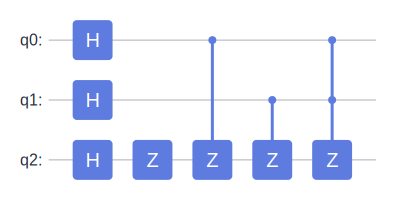

In [4]:
# pylint: disable=W0104
sim.reset()                                                      # 重置模拟器sim维护好的量子态，使得初始化的量子态为|000>

phase_inversion_qubit = [4]                                      # 翻转|4>态的相位
operator = bitphaseflip_operator(phase_inversion_qubit, n_qubits)# 调用我们定义好的bitphaseflip_operator()函数

circuit += operator                                              # 在量子线路circuit中添加翻转|4>态的相位所需的量子门

sim.apply_circuit(circuit)                                       # 通过模拟器sim再次运行搭建好的量子线路circuit

circuit.svg()                                                    # 打印此时的量子线路circuit

In [5]:
print(sim.get_qs(True))                                          # 打印模拟器sim中运行量子线路circuit后的末态

√2/4¦000⟩
√2/4¦001⟩
√2/4¦010⟩
√2/4¦011⟩
-√2/4¦100⟩
√2/4¦101⟩
√2/4¦110⟩
√2/4¦111⟩


从运行的结果看到此时的量子线路，以及$|100\rangle$​​的相位翻转为-1，运行如下代码：

In [6]:
print(int('100', 2))

4


从运行的结果看到，发生相位翻转的$|100\rangle$态即为我们希望相位翻转的$|4\rangle$态。

假设我们需要翻转除$|0\rangle$态以外的每个态的相位，运行如下代码：

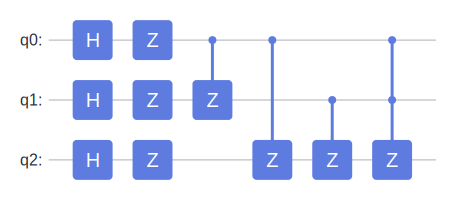

In [7]:
# pylint: disable=W0104
n_qubits = 3                                                     # 设定量子比特数为3
sim1 = Simulator('mqvector', n_qubits)                           # 使用mqvector模拟器，命名为sim1

operator1 = bitphaseflip_operator([i for i in range(1, pow(2, n_qubits))], n_qubits) # 调用我们定义好的bitphaseflip_operator()函数，翻转除|0>态以外的每个态的相位，命名为operator1

circuit1 = Circuit()                                             # 初始化量子线路，命名为circuit1
circuit1 += UN(H, n_qubits)                                      # 每位量子比特上执行H门操作
circuit1 += operator1                                            # 在量子线路circuit1中添加翻转除|0>态以外的每个态的相位所需的量子门

sim1.apply_circuit(circuit1)                                     # 通过模拟器sim1运行搭建好的量子线路circuit1

circuit1.svg()                                                         # 打印此时的量子线路circuit1

In [8]:
print(sim1.get_qs(True))                                         # 打印模拟器sim1中运行量子线路circuit1后的末态

√2/4¦000⟩
-√2/4¦001⟩
-√2/4¦010⟩
-√2/4¦011⟩
-√2/4¦100⟩
-√2/4¦101⟩
-√2/4¦110⟩
-√2/4¦111⟩


从运行的结果看到此时的量子线路，以及我们成功翻转除$|0\rangle$态以外的每个态的相位。

也就是说，我们定义的函数`bitphaseflip_operator()`可以实现Grover搜素算法中的Oracle算子$U_{\omega}$和条件相移算子$P$。

## 利用MindSpore Quantum实现Grover搜素算法实例

### 实例1：$n=3$​，$|\omega\rangle=|2\rangle$（单目标）

首先，我们需要定义$G$算子，运行如下代码：

In [9]:
def G(phase_inversion_qubit, n_qubits):           # 定义Grover搜索算法中的G算子
    operator = bitphaseflip_operator(phase_inversion_qubit, n_qubits)
    operator += UN(H, n_qubits)
    operator += bitphaseflip_operator([i for i in range(1, pow(2, n_qubits))], n_qubits)
    operator += UN(H, n_qubits)
    return operator

然后，我们根据Grover搜索算法的量子线路模型在MindSpore Quantum中搭建对应的量子线路：

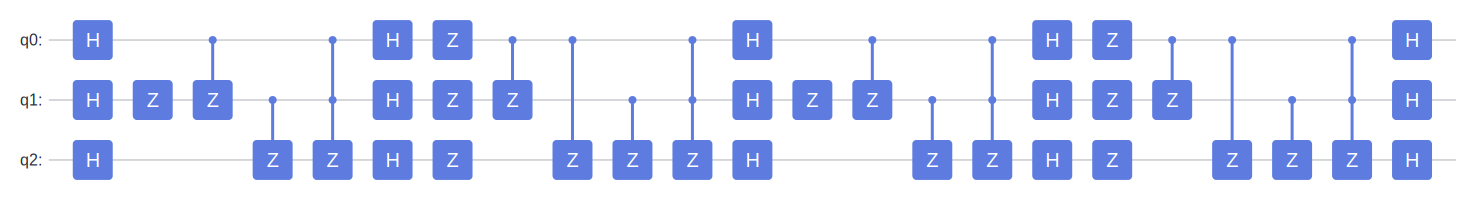

In [10]:
# pylint: disable=W0104
from numpy import pi, sqrt

n_qubits = 3                                      # 设定量子比特数为3
phase_inversion_qubit = [2]                       # 设定需要翻转相位的目标态，在这里翻转|2>态的相位

N = 2 ** (n_qubits)                               # 计算出数据库中元素的总个数
M = len(phase_inversion_qubit)                    # 计算出目标态的总个数

r = int(pi / 4 * sqrt(N / M))                     # 设定G算子迭代次数为r

sim2 = Simulator('mqvector', n_qubits)            # 使用mqvector模拟器，命名为sim2

circuit2 = Circuit()                              # 初始化量子线路，命名为circuit2
circuit2 += UN(H, n_qubits)                       # 每位量子比特上执行H门操作

for i in range(r):                                # 循环执行G算子r次
    circuit2 += G(phase_inversion_qubit, n_qubits)

sim2.apply_circuit(circuit2)                      # 通过模拟器sim2运行搭建好的量子线路circuit2

circuit2.svg()                                    # 打印此时的量子线路circuit2

In [11]:
print(sim2.get_qs(True))                          # 打印模拟器sim2中运行量子线路circuit2后的末态

-√2/16¦000⟩
-√2/16¦001⟩
0.9722718241315036¦010⟩
-√2/16¦011⟩
-√2/16¦100⟩
-√2/16¦101⟩
-√2/16¦110⟩
-√2/16¦111⟩


从运行的结果看到，$|010\rangle$态的振幅为0.9722718241315036，相比于其它的量子态，这是极大的振幅，也就是说，若我们测量此时的状态，将会以极大的概率得到目标态$|010\rangle$​，运行如下代码进行测量：

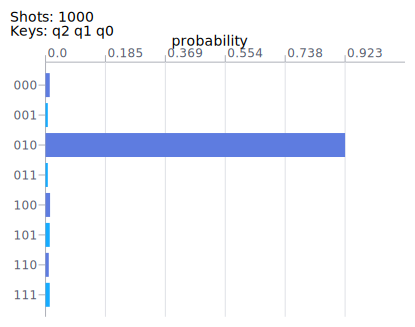

In [12]:
# pylint: disable=W0104
from mindquantum.core.gates import Measure

sim2.reset()                                      # 重置模拟器sim2维护好的量子态，使得初始化的量子态为|000>

circuit2 += UN(Measure(), circuit2.n_qubits)      # 对量子线路circuit2中的每一位量子比特添加测量门

result = sim2.sampling(circuit2, shots=1000)      # 通过模拟器sim2对量子线路circuit2进行1000次的采样
result.svg()                                      # 打印采样结果

从运行的结果看到，1000次采样中有923次的采样结果为`010`（由于具有随机性，每次运行有略微差距），将其转化为10进制数，运行如下代码：

In [13]:
print(int('010', 2))

2


从运行的结果看到，我们成功地搜索出$|2\rangle$态。

### 实例2：$n=5$，$|\omega\rangle=|5\rangle$和$|11\rangle$（多目标）

实例1中实现的是单目标搜索，现在我们尝试实现多目标搜索。首先，$G$算子已经定义好了，我们只需设定量子比特数和需要翻转相位的目标态，然后搭建对应的量子线路即可，运行如下代码：

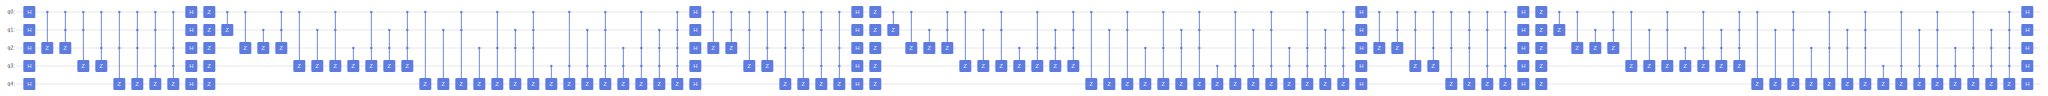

In [14]:
# pylint: disable=W0104
n_qubits = 5                                      # 设定量子比特数为5
phase_inversion_qubit = [5, 11]                   # 设定需要翻转相位的目标态，在这里翻转|5>态和|11>态的相位

N = 2 ** (n_qubits)                               # 计算出数据库中元素的总个数
M = len(phase_inversion_qubit)                    # 计算出目标态的总个数

r = int(pi / 4 * sqrt(N / M))                     # 设定G算子迭代次数为r

sim3 = Simulator('mqvector', n_qubits)            # 使用mqvector模拟器，命名为sim3

circuit3 = Circuit()                              # 初始化量子线路，命名为circuit3
circuit3 += UN(H, n_qubits)                       # 每位量子比特上执行H门操作

for i in range(r):                                # 循环执行G算子r次
    circuit3 += G(phase_inversion_qubit, n_qubits)

sim3.apply_circuit(circuit3)                      # 通过模拟器sim3运行搭建好的量子线路circuit3

circuit3.svg()                                          # 打印此时的量子线路circuit3

In [15]:
print(sim3.get_qs(True))                          # 打印模拟器sim3中运行量子线路circuit3后的末态

-0.035907766232129455¦00000⟩
-0.035907766232129365¦00001⟩
-0.03590776623212947¦00010⟩
-0.035907766232129254¦00011⟩
-0.03590776623212947¦00100⟩
0.6932961018664989¦00101⟩
-0.035907766232129455¦00110⟩
-0.035907766232129365¦00111⟩
-0.035907766232129455¦01000⟩
-0.035907766232129365¦01001⟩
-0.03590776623212947¦01010⟩
0.6932961018664989¦01011⟩
-0.03590776623212947¦01100⟩
-0.035907766232129254¦01101⟩
-0.035907766232129455¦01110⟩
-0.035907766232129365¦01111⟩
-0.0359077662321294¦10000⟩
-0.03590776623212939¦10001⟩
-0.03590776623212936¦10010⟩
-0.03590776623212949¦10011⟩
-0.03590776623212936¦10100⟩
-0.03590776623212949¦10101⟩
-0.0359077662321294¦10110⟩
-0.03590776623212939¦10111⟩
-0.0359077662321294¦11000⟩
-0.03590776623212939¦11001⟩
-0.03590776623212936¦11010⟩
-0.03590776623212949¦11011⟩
-0.03590776623212936¦11100⟩
-0.03590776623212949¦11101⟩
-0.0359077662321294¦11110⟩
-0.03590776623212939¦11111⟩


从运行的结果看到，$|00101\rangle$​​和$|01011\rangle$​​态的振幅均为0.6932961018664989，相比于其它的量子态，这是极大的振幅，也就是说，若我们测量此时的状态，将会以极大的概率得到目标态$|00101\rangle$​​和$|01011\rangle$​​态，运行如下代码进行测量：

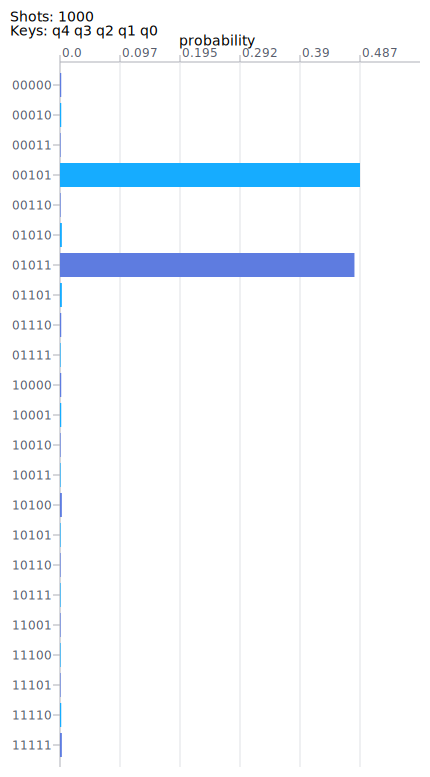

In [16]:
# pylint: disable=W0104
sim3.reset()                                      # 重置模拟器sim3维护好的量子态，使得初始化的量子态为|00000>

circuit3 += UN(Measure(), circuit3.n_qubits)      # 对量子线路circuit3中的每一位量子比特添加测量门

result1 = sim3.sampling(circuit3, shots=1000)     # 通过模拟器sim3对量子线路circuit3进行1000次的采样
result1.svg()                                     # 打印采样结果

从运行的结果看到，1000次采样中有487次的采样结果为`00101`和478次的采样结果为`01011`（由于具有随机性，每次运行会略有不同），将其转化为10进制数，运行如下代码：

In [17]:
print(int('00101', 2))
print(int('01011', 2))

5
11


从运行的结果看到，我们成功地搜索出$|5\rangle$​​和$|11\rangle$​​​​​态。

至此，我们介绍了Grover搜索算法的基本原理，以及通过两个具体的小例子来展示如何利用MindSpore Quantum实现该算法！赶紧动手体验一下量子编程的乐趣吧！

## 龙算法

除了在规模为4的数据库中找1个数据的场景，Grover算法不能够精确的搜索出所标记态。清华大学龙桂鲁教授在Grover算法基础之上提出量子精确搜索算法龙算法[3]，能够以准确率为1的概率在所有场景中搜索出目标态。其主要思想是将Grover算子改写为如下的算子，

$$L = -H^{\otimes n} R_0 H^{\otimes n} R_\tau$$

其中：$R_0 = (I+(e^{i\theta}-1)\left|0\right>\left<0\right|)$，$R_\tau = (I+(e^{i\theta}-1)\left|\tau\right>\left<\tau\right|)$。在满足相位匹配条件时，

$$\theta = 2\arcsin\left(\sin\beta\sin\left(\frac{\pi}{4J_s+6}\right)\right)$$

我们只需作用$J_s+1$次龙算子，就可以以概率1找到目标态，这里$\beta=\arcsin{\sqrt{M/N}}$，$M$为标记态个数，$N$为数据库大小，$J_s>=[((\pi/2)-\beta)/\beta]$。下面我们用MindSpore Quantum来实现。

### 一般角度相位转动线路

借助于辅助比特，我们搭建某个计算基矢一般角度相位转动线路。

In [18]:
from mindquantum.core.gates import X, PhaseShift
from mindquantum.core.circuit import Circuit
def change_phase_with_anclia(which, n_qubits, phase):
    c = Circuit()
    which_bit = bin(which)[2:].zfill(n_qubits)[::-1]
    polarity_circ = Circuit()
    for idx, bit in enumerate(which_bit):
        if bit == "0":
            polarity_circ += X.on(idx)
    c += polarity_circ
    c += PhaseShift(phase).on(n_qubits, list(range(n_qubits)))
    c += polarity_circ
    return c

### 搭建龙算子

In [19]:
from mindquantum.core.gates import BARRIER, Z

def L(which, n_qubits, theta, phi):
    U = UN(H, n_qubits)
    R0 = change_phase_with_anclia(0, n_qubits, theta)
    R_t = change_phase_with_anclia(which, n_qubits, phi)
    g_ops = R_t + BARRIER + U + BARRIER + R0 + BARRIER + U + BARRIER
    g_ops += Z.on(n_qubits)
    return g_ops

## 完成量子精确搜索算法：龙算法

这里我们以3比特数据库中搜索$\left|2\right>$态为例，完成龙算法。

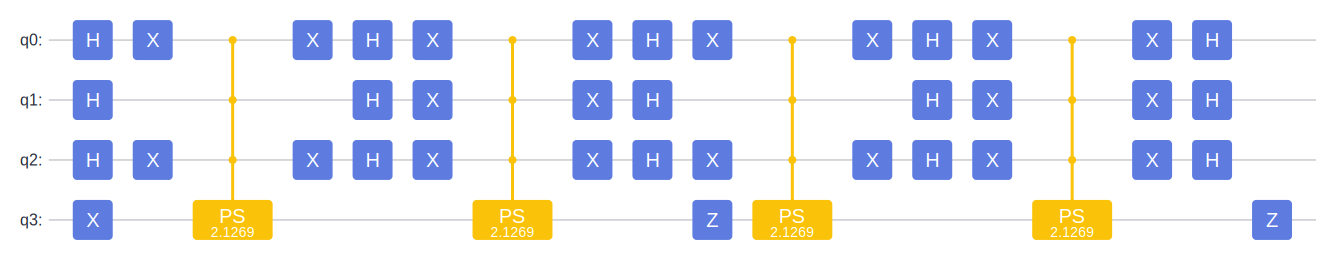

In [20]:
import numpy as np
from mindquantum.core.gates import H
from mindquantum.core.circuit import UN
n_qubits = 3
will_find = 2
beta = np.arcsin(np.sqrt(1 / 2**n_qubits))
Js = int((np.pi / 2 - beta) / 2 / beta)
theta = 2 * np.arcsin(np.sin(np.pi / (4 * Js + 6)) / np.sin(beta))
phi = theta

g = L(will_find, n_qubits, theta, phi)            # 构建用于精确搜索的龙算子

circ = UN(H, n_qubits) + X.on(n_qubits)
for i in range(Js + 1):
    circ += g
circ.svg()

接下来，我们计算线路的量子态。

In [21]:
print(circ.get_qs(ket=True))

(0.048708136684586345-0.9988130542902997j)¦1010⟩


发现，除去相位，我们可以精确的得到目标态。通过采样，我们也可以得到如下类似的结果。

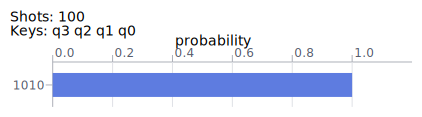

In [22]:
from mindquantum.simulator import Simulator
from mindquantum.core.gates import Measure

sim = Simulator('mqvector', circ.n_qubits)
res = sim.sampling(circ + UN(Measure(), circ.n_qubits), shots=100)
res.svg()

In [23]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

### **参考文献：**

\[1\] L. K. Grover, A fast quantum mechanical algorithm for database search\[C\]// Proceedings of the twenty-eighth annual ACM symposium on Theory of computing. ACM, 1996: 212-219.

\[2\] G. Brassard, P. Hoyer, M. Mosca, et al. Quantum amplitude amplification and estimation\[J\]. Contemporary Mathematics, 2002, 305: 53-74.

\[3\] Long G L. Grover algorithm with zero theoretical failure rate. Physical Rev A, 2001, 64: 022307.